# 🏆 Predicting the NBA Finals Winner

Brayden Stach, Julian Loutzenhiser, Katherine Nunn

---

# 🛠️ Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

---

# 📝 Project Plan

We are going to be analyzing team data in order to come up with a power ranking of all of the basketball teams in the Playoffs. We will then compare certain matchups based on this ranking and use predictive modeling in order to predict what team is most likely to win it all.

1) 📥 Load NBA team data
2) 🧹 Clean the dataset (any empty columns / rows)
3) 🏆 Use an all around statistic such as SRS (SRS = Simple Rating System) to try to come up with a power ranking based on the regular season
4) 📈 Calculate an average of how much each team has done better / worse in the playoffs over the last ~5 years
5) 🧠 Integrate the % that each team does better in the playoffs with their power ranking score to come up with a playoff power ranking
6) 🥇 Compare each teams playoff power ranking against each other to predict who will win

This is a very simple plan that would be a good spot to start I believe. We will probably have to get additional data such as player data in order to make it more accurate. Ideally, we would also take into account trades that happen midway through the season looking more at the second half of games played. It might also be important to look at injuries, team age, experience in the playoffs, home court advantage, and other factors that might influence a teams ability to win.

---

# 🎯 Research Questions

**Main Research Question:**
- ➡️ Can we predict the winner of the 2025 NBA Finals based on team regular season performance, adjusted for playoff success trends?

**Related Research Questions:**
1. 📈 How well does the Simple Rating System (SRS) predict playoff success compared to regular season wins alone?
2. 🏀 If we are required to add player data in order to do the Main Research Question, an additional bonus fun question to answer would be who deserves the MVP award this season based on stats?
3. 🛡️⚡ Is offensive or defensive rating more important in predicting playoff performance?
4. 📅🏆 Do regular season records reliably predict Finals winners?
5. 🏃‍♂️💨 Do high-tempo teams (e.g., high possessions/game) have a better shot at the Finals?
6. 🔍🏆 Has the profile of a Finals-winning team changed over the years?
7. Who is the closest player in NBA history to Lebron James (The Goat).

---

# 📊 Data Description

Our dataset contains information about NBA teams' performance during the regular season.  
It includes 31 columns and one row per team.

The key features are:

| Column Name   | Description |
|---------------|-------------|
| Rk            | Unique ID |
| Team          | Name of the NBA team |
| Age           | Average age of players on the team |
| W             | Total wins during the regular season |
| L             | Total losses during the regular season |
| PW            | Pythagorean wins (estimated wins based on points scored and allowed) |
| PL            | Pythagorean losses |
| MOV           | Margin of victory (average point differential per game) |
| SOS           | Strength of schedule (relative difficulty of opponents), 0 is average, the larger the number the tougher the schedule |
| SRS           | Simple Rating System (MOV adjusted for SOS — a measure of overall team strength), very good all-in-one statistic |
| ORtg          | Offensive Rating (points scored per 100 possessions) |
| DRtg          | Defensive Rating (points allowed per 100 possessions) |
| NRtg          | Net Rating (Offensive Rating - Defensive Rating, overall team efficiency) |
| Pace          | Number of possessions per 48 minutes (how fast the team plays) |
| FTr           | Free Throw Rate (ratio of free throws to field goal attempts) |
| 3PAr          | Three-Point Attempt Rate (percentage of shots that are three-pointers) |
| TS%           | True Shooting Percentage (adjusted shooting efficiency including free throws and threes) |
| **Offensive Four Factors** |  |
| eFG%          | Effective field goal percentage (adjusted for 3-pointers being worth more) |
| TOV%          | Turnover percentage (percentage of possessions ending in a turnover) |
| ORB%          | Offensive rebounding percentage (offensive rebounds per available opportunity) |
| FT/FGA        | Free throws per field goal attempt |
| **Defensive Four Factors** |  |
| eFG%.1        | Opponent effective field goal percentage |
| TOV%.1        | Opponent turnover percentage |
| DRB%          | Defensive rebounding percentage (defensive rebounds per available opportunity) |
| FT/FGA.1      | Opponent free throws per field goal attempt |



---

**General Observations:**
- 🛠️ There are a few unnamed columns (`Unnamed: 22`, `Unnamed: 27`) that appear to contain only missing values (NaN) and may need to be dropped.
- 🏟️ Columns related to attendance and arenas (`Arena`, `Attend.`, `Attend./G`) may not be highly relevant to predicting playoff outcomes and could also be dropped during cleaning. On top of this we could also look to drop a few other columns if we end up not using them (because SRS is a combined metric that does a lot of the work for us).
- 📈 Important metrics for our project include **SRS**, **MOV**, and **SOS**, which relate directly to team strength and game performance.


In [2]:
# Load the data
teamdata = pd.read_csv('teamdata.csv', skiprows=1)

# Drop the league average row
teamdata = teamdata[teamdata['Team'] != 'League Average']

# Reset the index after dropping
teamdata = teamdata.reset_index(drop=True)

# Now safe to work with
teamdata.head(32)

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS▼,...,FT/FGA,Unnamed: 22,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Unnamed: 27,Arena,Attend.,Attend./G
0,1.0,Oklahoma City Thunder*,24.8,68.0,14.0,68,14,12.87,-0.16,12.70,...,0.180,NaN,0.513,14.9,74.6,0.211,NaN,Paycom Center,754832,17973
1,2.0,Cleveland Cavaliers*,26.6,64.0,18.0,62,20,9.54,-0.73,8.81,...,0.187,NaN,0.528,12.6,74.8,0.181,NaN,Rocket Arena,796712,19432
2,3.0,Boston Celtics*,28.9,61.0,21.0,62,20,9.11,-0.83,8.28,...,0.169,NaN,0.522,11.6,76.0,0.154,NaN,TD Garden,785396,19156
3,4.0,Minnesota Timberwolves*,27.2,49.0,33.0,53,29,5.00,0.15,5.15,...,0.196,NaN,0.532,13.2,75.1,0.178,NaN,Target Center,772249,18835
4,5.0,Houston Rockets*,24.9,52.0,30.0,52,30,4.51,0.45,4.97,...,0.178,NaN,0.528,12.8,76.2,0.186,NaN,Toyota Center,716853,17484
5,6.0,Los Angeles Clippers*,29.7,50.0,32.0,53,29,4.66,0.18,4.84,...,0.200,NaN,0.536,13.7,77.5,0.189,NaN,Intuit Dome,679593,16575
6,7.0,Memphis Grizzlies*,24.7,48.0,34.0,52,30,4.85,-0.06,4.79,...,0.196,NaN,0.533,12.9,74.9,0.206,NaN,FedEx Forum,683067,16660
7,8.0,Denver Nuggets*,27.0,50.0,32.0,50,32,3.89,0.08,3.97,...,0.200,NaN,0.542,11.3,74.6,0.173,NaN,Ball Arena,811211,19786
8,9.0,New York Knicks*,27.5,51.0,31.0,51,31,4.10,-0.51,3.59,...,0.186,NaN,0.549,13.1,74.5,0.176,NaN,Madison Square Garden (IV),811794,19800
9,10.0,Golden State Warriors*,28.6,48.0,34.0,49,33,3.30,0.25,3.56,...,0.187,NaN,0.541,14.1,75.6,0.189,NaN,Chase Center,740624,18064


---

# 🧹 Clean the Data

In [6]:
# 1. Drop 'Unnamed' columns
teamdata = teamdata.drop(columns=[col for col in teamdata.columns if 'Unnamed' in col])

# 2. Drop 'Arena', 'Attend.', and 'Attend./G' columns
teamdata = teamdata.drop(columns=['Arena', 'Attend.', 'Attend./G'])

# 3. Double-check missing values after dropping
print(teamdata.isnull().sum())

# 4. Confirm data types
print(teamdata.dtypes)

Rk          0
Team        0
Age         0
W           0
L           0
PW          0
PL          0
MOV         0
SOS         0
SRS▼        0
ORtg        0
DRtg        0
NRtg        0
Pace        0
FTr         0
3PAr        0
TS%         0
eFG%        0
TOV%        0
ORB%        0
FT/FGA      0
eFG%.1      0
TOV%.1      0
DRB%        0
FT/FGA.1    0
dtype: int64
Rk          float64
Team         object
Age         float64
W           float64
L           float64
PW            int64
PL            int64
MOV         float64
SOS         float64
SRS▼        float64
ORtg        float64
DRtg        float64
NRtg        float64
Pace        float64
FTr         float64
3PAr        float64
TS%         float64
eFG%        float64
TOV%        float64
ORB%        float64
FT/FGA      float64
eFG%.1      float64
TOV%.1      float64
DRB%        float64
FT/FGA.1    float64
dtype: object


---

# 🏆 Build Power Ranking

In [7]:
# 1. Sort teams by SRS (Simple Rating System) in descending order
power_ranking = teamdata.sort_values(by='SRS▼', ascending=False).reset_index(drop=True)


# 3. Display the top teams
power_ranking[['Team', 'SRS▼']]

,Team,SRS▼
0,Oklahoma City Thunder,12.70
1,Cleveland Cavaliers,8.81
2,Boston Celtics,8.28
3,Minnesota Timberwolves,5.15
4,Houston Rockets,4.97
5,Los Angeles Clippers,4.84
6,Memphis Grizzlies,4.79
7,Denver Nuggets,3.97
8,New York Knicks,3.59
9,Golden State Warriors,3.56


In [8]:
playoff_teams = [
    'Oklahoma City Thunder', 'Memphis Grizzlies', 'Denver Nuggets', 'Los Angeles Clippers',
    'Los Angeles Lakers', 'Minnesota Timberwolves', 'Houston Rockets', 'Golden State Warriors',
    'Cleveland Cavaliers', 'Miami Heat', 'Indiana Pacers', 'Milwaukee Bucks',
    'New York Knicks', 'Detroit Pistons', 'Boston Celtics', 'Orlando Magic'
]

# Remove '*' from the team names first
teamdata['Team'] = teamdata['Team'].str.replace('*', '', regex=False).str.strip()

# Now filter only playoff teams
teamdata_playoffs = teamdata[teamdata['Team'].isin(playoff_teams)].reset_index(drop=True)

# Quick check
print(teamdata_playoffs[['Team', 'SRS▼']])

                      Team   SRS▼
0    Oklahoma City Thunder  12.70
1      Cleveland Cavaliers   8.81
2           Boston Celtics   8.28
3   Minnesota Timberwolves   5.15
4          Houston Rockets   4.97
5     Los Angeles Clippers   4.84
6        Memphis Grizzlies   4.79
7           Denver Nuggets   3.97
8          New York Knicks   3.59
9    Golden State Warriors   3.56
10         Milwaukee Bucks   2.12
11         Detroit Pistons   1.73
12          Indiana Pacers   1.68
13      Los Angeles Lakers   1.45
14              Miami Heat   0.11
15           Orlando Magic  -0.70


These are all of the playoff teams listed. Historically, the team that has won the finals has almost always been in the top 5 of SRS ratings in the regular season.

---

# 📚 K-Means Clustering

We can use K-Means clustering in order to find out how similar each playoff team is to each other. We can come up with distinct groupings to better understand which team actually has a chance at winning the championship. We could order these groupings something like the favorites and then just the contenders.

---

# 🧹 Drop Categorical Columns and Scale Features

In [17]:
# Keep only numeric columns
teamdata_playoffs_numeric = teamdata_playoffs.select_dtypes(include=['float64', 'int64'])

# Save feature names
feature_names = teamdata_playoffs_numeric.columns

# Scale the numeric features
scaler = StandardScaler()
teamdata_playoffs_scaled = scaler.fit_transform(teamdata_playoffs_numeric)

---

# 📊 Find the Optimal Number of Clusters (Elbow Method)

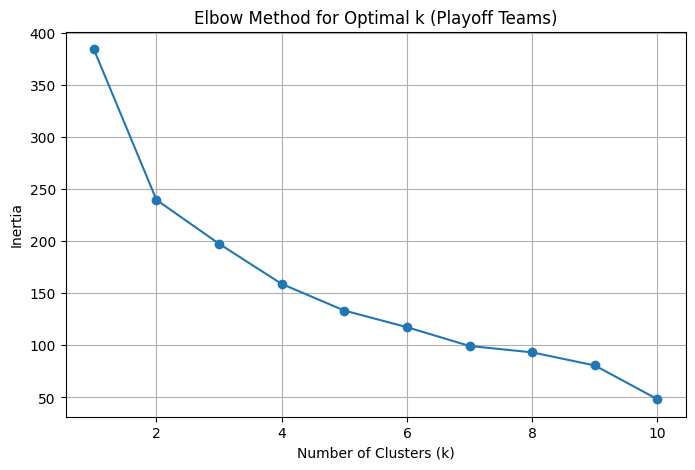

In [12]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(teamdata_playoffs_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (Playoff Teams)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

From the elbow method we can see that the decrease starts to level out at around 2 clusters.

---

# 📊 Find the Optimal Number of Clusters (Silhouette Method)

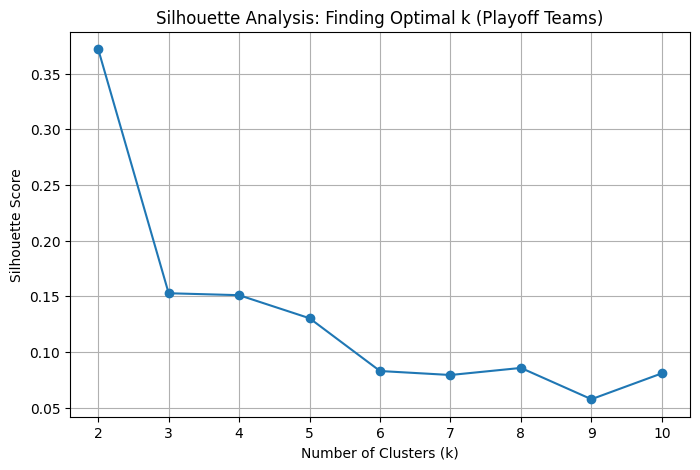

In [13]:
# Range of k values (must start at 2 because silhouette needs at least 2 clusters)
k_range = range(2, 11)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(teamdata_playoffs_scaled)
    score = silhouette_score(teamdata_playoffs_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis: Finding Optimal k (Playoff Teams)')
plt.grid(True)
plt.show()

The silhouette method strongly suggests that we should only use two clusters as well.

---

# 🛠️ Apply K-Means Clustering with k=2

In [14]:
# Apply KMeans clustering with k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
teamdata_playoffs['Cluster'] = kmeans.fit_predict(teamdata_playoffs_scaled)

# Preview the playoff teams with their cluster assignments
teamdata_playoffs[['Team', 'Cluster']].head()

,Team,Cluster
0,Oklahoma City Thunder,0
1,Cleveland Cavaliers,0
2,Boston Celtics,0
3,Minnesota Timberwolves,1
4,Houston Rockets,1


---

# 📋 Find Averages Among Clusters

In [27]:
# Get the cluster centers in scaled units
centroids_scaled = kmeans.cluster_centers_

# Inverse transform to get original units (undo scaling)
centroids_unscaled = scaler.inverse_transform(centroids_scaled)

# Create a DataFrame to show each cluster's average feature values
centroids_df = pd.DataFrame(
    centroids_unscaled, 
    columns=feature_names
)

# Rename the index to make it pretty
centroids_df.index = [f"Cluster {i}" for i in range(k)]

centroids_df

,Rk,Age,W,L,PW,PL,MOV,SOS,SRS▼,ORtg,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
Cluster 0,2.000000,26.766667,64.333333,17.666667,64.000000,18.000000,10.506667,-0.573333,9.930000,120.866667,...,0.470667,0.597000,0.566333,10.900000,25.266667,0.178667,0.521000,13.033333,75.133333,0.182000
Cluster 1,10.153846,26.930769,47.538462,34.461538,48.153846,33.846154,2.967692,-0.103077,2.866154,115.715385,...,0.409385,0.582308,0.549077,12.538462,25.253846,0.194615,0.538385,12.969231,75.569231,0.186923


This lets us see the average statistics of each cluster and what each cluster is being grouped by.

---

# 🎨 Visualize the Clusters using PCA

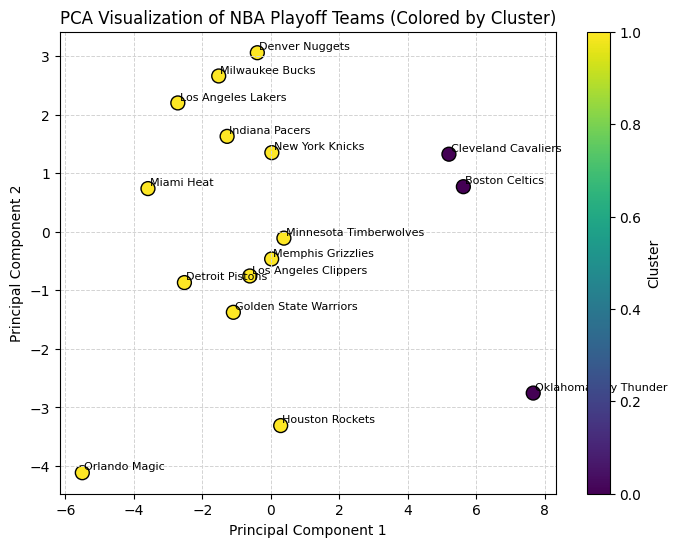

In [24]:
# Reduce dimensions to 2 principal components for visualization
pca = PCA(n_components=2)
teamdata_playoffs_pca = pca.fit_transform(teamdata_playoffs_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(8,6))
plt.scatter(
    teamdata_playoffs_pca[:,0], 
    teamdata_playoffs_pca[:,1], 
    c=teamdata_playoffs['Cluster'], 
    cmap='viridis', 
    s=100, 
    edgecolor='k'
)
for i, team in enumerate(teamdata_playoffs['Team']):
    plt.text(
        teamdata_playoffs_pca[i,0]+0.05, 
        teamdata_playoffs_pca[i,1]+0.05, 
        team, 
        fontsize=8
    )
plt.title('PCA Visualization of NBA Playoff Teams (Colored by Cluster)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.7)
plt.colorbar(label='Cluster')
plt.show()

This visualization shows that the Cavs, Celtics, and Thunder are the 3 statistical anomalies in this dataset. This does make sense because these 3 teams were by a pretty wide margin the best performers in the regular season.

---

# 🧠 What the Principal Components mean

In [29]:
# Get the PCA components
pca_components = pca.components_

# Create a DataFrame to visualize
pca_loadings = pd.DataFrame(
    pca_components.T, 
    columns=['PC1', 'PC2'], 
    index=feature_names
)

pca_loadings

,PC1,PC2
Rk,-0.267670,0.040492
Age,-0.004609,0.248290
W,0.282266,0.006377
L,-0.282266,-0.006377
PW,0.293179,-0.050846
PL,-0.293179,0.050846
MOV,0.294013,-0.052062
SOS,-0.059622,-0.105880
SRS▼,0.290505,-0.064790
ORtg,0.253246,0.220804


It seems as though PC1 is affected very heavily by Wins, Losses, SRS, Offensive Rating, Net Rating, Margin of Victory, and PL. This means that a higher PC1 = Better Team Performance. PC2 is based off of a mixture of shooting efficiency and defense but is not as clear cut as to whether higher = better as PC1 was.

---